--------------------
#### When embeddings fails to retrieve (good results)
--------------------------

In [30]:
from helper_utils import load_chroma, word_wrap

In [22]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [23]:
embedding_function = SentenceTransformerEmbeddingFunction()

In [24]:
%%time
chroma_collection = load_chroma(filename          = r'./data/microsoft_annual_report_2022.pdf', 
                                collection_name   = 'microsoft_annual_report_2022', 
                                embedding_function= embedding_function)
chroma_collection.count()

D:\ANACONDA\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


UniqueConstraintError: Collection microsoft_annual_report_2022 already exists

#### Visualize the embedding space

In [ ]:
#pip install umap

In [ ]:
#pip install umap-learn

In [1]:
import umap.umap_ as umap  # Correct import
import numpy as np
from tqdm import tqdm

In [26]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

**Why UMAP**

| Visualization Method | Strengths                                               | Weaknesses                                         | Recommended Use Cases                         |
|----------------------|--------------------------------------------------------|---------------------------------------------------|-----------------------------------------------|
| PCA                  | - Fast computation<br>- Good for preserving global structure | - Assumes linearity<br>- Poor at capturing non-linear relationships | - Initial exploration of data<br>- High-dimensional datasets with clear structure |
| Non-Linear PCA       | - Captures non-linear relationships                    | - More complex than PCA<br>- Slower computation   | - When data has known non-linear structures  |
| t-SNE                | - Excellent for visualizing local structures<br>- Good at separating clusters | - Computationally expensive<br>- Does not preserve global structure well | - Detailed exploration of clusters<br>- Smaller datasets (usually < 10,000 samples) |
| UMAP                 | - Preserves both local and global structures<br>- Faster than t-SNE | - Slightly more complex to tune<br>- Interpretability can be lower | - Large datasets<br>- Visualizing high-dimensional data with complex structures |


In [28]:
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

D:\ANACONDA\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [29]:
def project_embeddings(embeddings, umap_transform):
    
    umap_embeddings = np.empty((len(embeddings),2))
    
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
        
    return umap_embeddings   

In [ ]:
%%time
# this takes a long time on CPUs
# try Colab
#projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

In [5]:
import pickle

In [ ]:
# Assuming 'projected_dataset_embeddings' is the transformed dataset
with open('projected_embeddings.pkl', 'wb') as f:
    pickle.dump(projected_dataset_embeddings, f)

In [31]:
with open('projected_embeddings.pkl', 'rb') as f:
    projected_dataset_embeddings = pickle.load(f)

(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

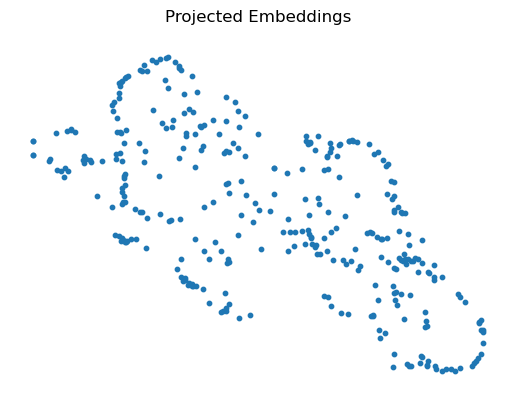

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

#### Relevancy and Distraction

In [33]:
query   = "What has been the investment in research and development?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

**Observation**
- some documents are related to revenue
- some are related to words like "research and development"
- some are related to costs but not revenuw

In [34]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

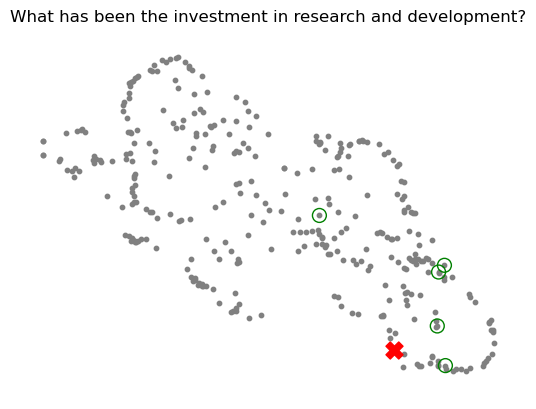

In [37]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

**Observation**
- the retrieved documents do not look like the closest neighbors
- some even look like outliers

Another Query ...

In [38]:
query   = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [39]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

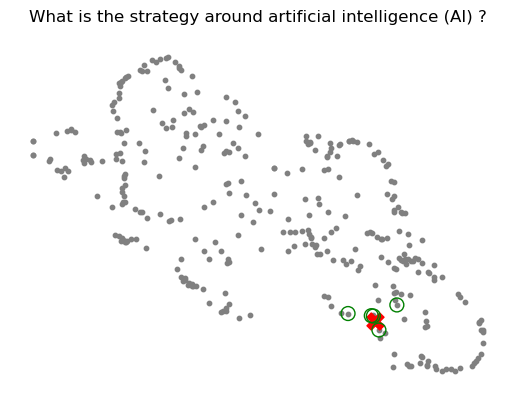

In [40]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

**Observation**

- the retrived documents seem to be from a similar pool of documents
- but some of the retrieved documents do not seem related

Another Query ...

query   = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

In [42]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

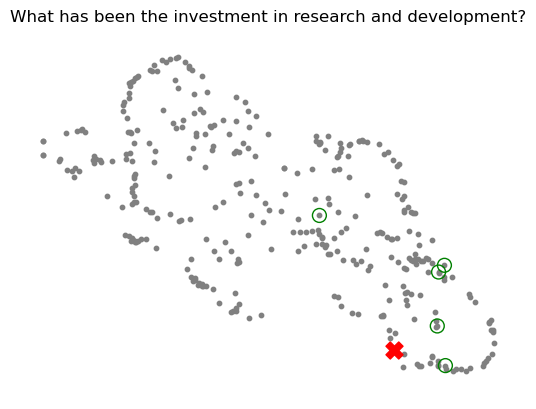

In [43]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

**Observation**
- there are distractors in the results
- results are quite spread out


Another Query ... some thing very unrelated

In [44]:
query   = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

we use metrics in assessing the performance of our business and to make
informed decisions regarding the allocation of resources. we disclose
metrics to enable investors to evaluate progress against our ambitions,
provide transparency into performance trends, and reflect the continued
evolution of our products and services. our commercial and other
business metrics are fundamentally connected based on how customers use
our products and

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our eff

In [45]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


(-2.6169466614723205,
 8.120241367816925,
 2.8080547571182253,
 10.272378611564637)

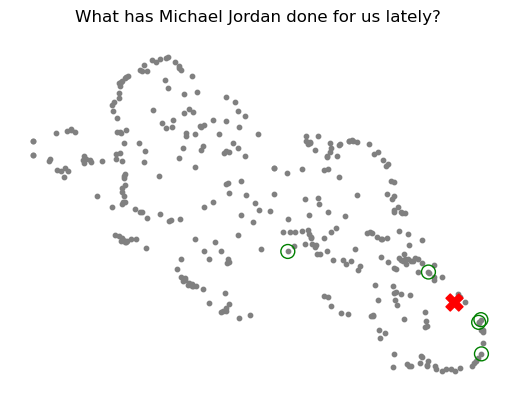

In [46]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

**Observation**
- all distractors (likely)

Try more queries ....

------------------------------
#### How does UMAP work
----------------------

- **UMAP (Uniform Manifold Approximation and Projection)** is a dimensionality reduction technique that excels at preserving both local and global structure of high-dimensional data.

- **Goal**: Reduces high-dimensional data into lower dimensions (usually 2 or 3), preserving relationships between data points.


**Local Structure**
- `Local structure` refers to the relationships between nearby points in high-dimensional space. The goal is to keep close points in the original high-dimensional space close to each other in the low-dimensional embedding as well.
- Example of Local Structure:
    - Imagine a dataset of handwritten digits (like MNIST), where each digit image is represented by 784 dimensions (28x28 pixels).
    - Two images of the digit "1" may be very similar, differing only by small variations in handwriting.
    - These two images are locally related because they represent the same digit and should be close in high-dimensional space.
    - When using a dimensionality reduction technique like UMAP, the algorithm should keep these similar images near each other in the 2D or 3D projection.

**Global Structure**
- `Global structure` refers to the broader, overarching relationships between clusters or groups of points in the dataset. It focuses on ensuring that the overall layout of points in the low-dimensional space reflects the true structure of the dataset.
- Example of Global Structure:
    - In the same MNIST dataset, images of different digits (e.g., "1" and "7") might form distinct clusters.
    - These clusters are globally related. While individual images of "1" and "7" might be close to each other in some cases, at the global scale, images of "1" should generally form a separate cluster from images of "7."
    - Preserving global structure means that UMAP should keep these clusters of different digits separated in the 2D or 3D embedding.


#### if the model preserves the local structures, then would it not preserve the global structure as well, overall?

**Why Local Structure Doesn't Guarantee Global Structure**
- Local Structure Preservation:
    - If a dimensionality reduction method like UMAP prioritizes local structure, it ensures that neighboring points in the high-dimensional space stay neighbors in the low-dimensional space.
    - However, focusing too much on local structure may cause the model to distort the relative positions of distant points.
    - For instance, multiple small, well-preserved local neighborhoods could be misplaced with respect to each other, resulting in the loss of global structure.

**Why Global Structure Doesn't Guarantee Local Structure**
- Global Structure Preservation:
    - If a dimensionality reduction method tries to maintain the overall geometry of the data, it might correctly place clusters far apart (global structure), but the finer details within each cluster (local structure) could be distorted.


| Method      | Focus                          | Description                                                                                 |
|-------------|--------------------------------|---------------------------------------------------------------------------------------------|
| **UMAP**    | Balances local and global      | - Smaller `n_neighbors` focuses more on local structure (better preservation of nearest neighbors). <br> - Larger `n_neighbors` gives more attention to global structure (preserving relationships between larger groups). |
| **t-SNE**   | Prioritizes local structure    | - Heavily preserves nearby points, but global relationships between clusters can be distorted. |
| **PCA/SVD** | Focus on global structure      | - Aims to preserve global structure by maximizing variance, but may not maintain local clusters effectively compared to non-linear methods like UMAP or t-SNE. |


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

In [4]:
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)

In [5]:
# takes some time ... 3 - 5 mins
# Fit and transform the data
X_umap = umap_model.fit_transform(X)

D:\ANACONDA\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


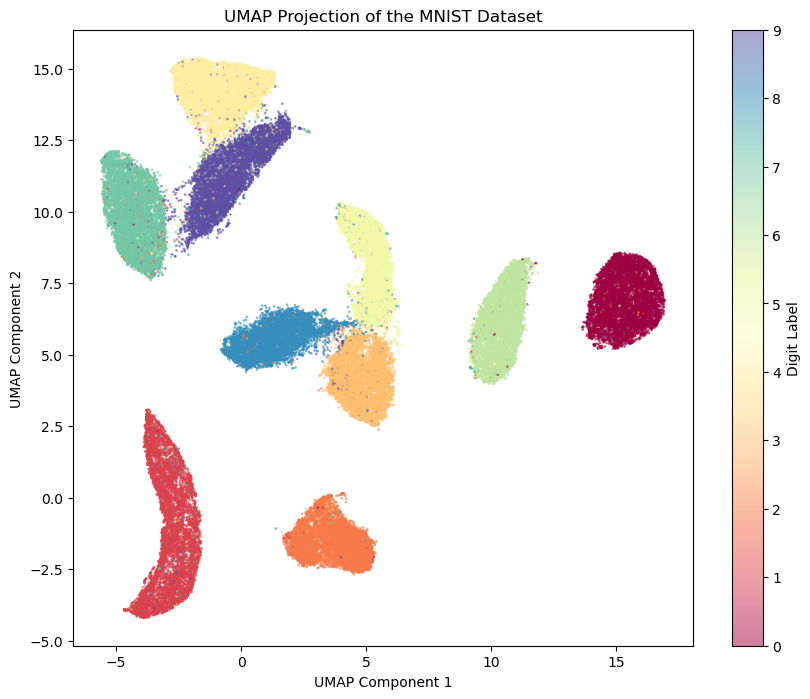

In [6]:
# Plot the UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', s=1, alpha=0.5)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('UMAP Projection of the MNIST Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [7]:
from sklearn.decomposition import TruncatedSVD

In [8]:
# Initialize SVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Fit and transform the data
X_svd = svd.fit_transform(X)

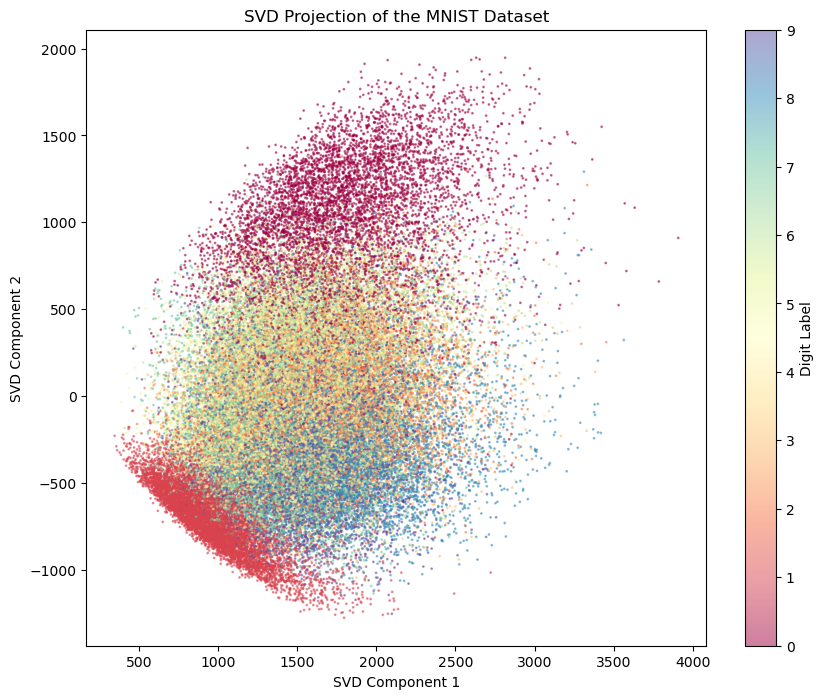

In [9]:
# Plot the SVD results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='Spectral', s=1, alpha=0.5)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('SVD Projection of the MNIST Dataset')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()

In [10]:
from sklearn.manifold import TSNE

In [11]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

In [13]:
# Fit and transform the data
X_tsne = tsne.fit_transform(X)

AttributeError: 'NoneType' object has no attribute 'split'

In [14]:
from sklearn.decomposition import PCA

In [15]:
# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform the data
X_pca = pca.fit_transform(X)

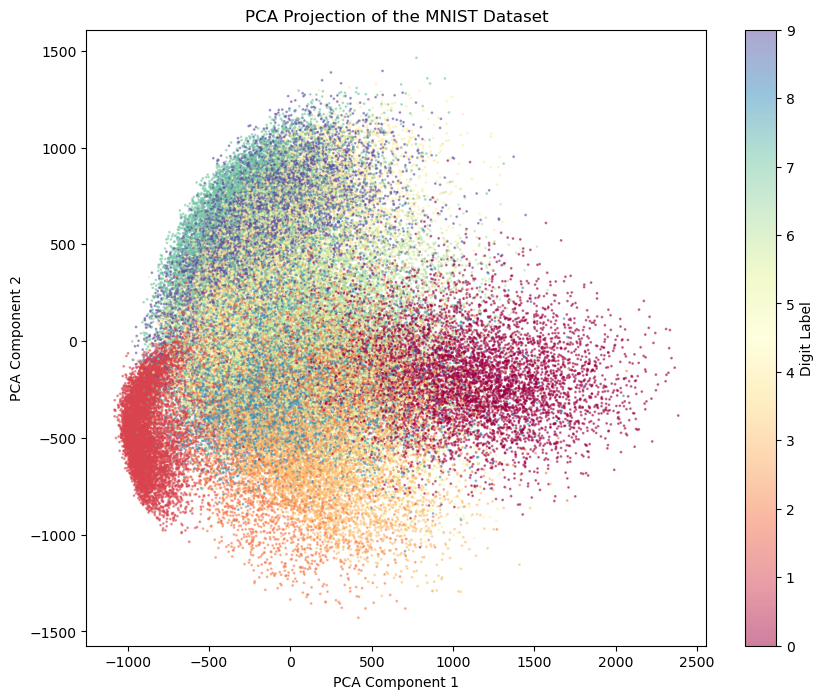

In [16]:
# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', s=1, alpha=0.5)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('PCA Projection of the MNIST Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()